<a href="https://colab.research.google.com/github/erfan-sams/sexsim-detection/blob/main/transformer-sexsim-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

#[Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

#### Imports

In [ ]:
import pandas as pd
import numpy as np
import statistics
from collections import Counter
from gensim import utils
import gensim.parsing.preprocessing as gsp

import re
import spacy

import random

In [ ]:
nlp = spacy.load("en_core_web_sm")


### Functions:

In [ ]:
def majority_vote(list):
  yes_count = 0
  for i in list:
    if i =='YES':
      yes_count +=1

  if yes_count > 3:
    return 1
  elif yes_count < 3:
    return 0
  return None

#### Reading the Json File

In [ ]:
def reading_file(file):
    df = pd.read_json(file)
    df = df.T
    df = df[(df['lang'] == 'en')]
    df['hard_label_task1'] = df.labels_task1.apply(majority_vote)
    df = df[df['hard_label_task1'].notna()]
    df = df.reset_index(drop=True)
    df = df[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']]

    return df

# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [ ]:
def clean_text(s):
    # s = s.lower()
    s = re.sub(r'http\S+', '', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub(r'#\S+', '', s)
    s = re.sub(r'/\S+', '', s)
    s = ''.join(char for char in s if char.isalpha() or char.isspace())
    s = re.sub(r'\s+', ' ', s).strip()

    doc = nlp(s)
    lemmatized_text = " ".join([token.lemma_ for token in doc])

    return lemmatized_text

In [ ]:
train_df = reading_file('/content/drive/MyDrive/unibo-3/NLP/assign_1/data/training.json')
valid_df = reading_file('/content/drive/MyDrive/unibo-3/NLP/assign_1/data/validation.json')
test_df = reading_file('/content/drive/MyDrive/unibo-3/NLP/assign_1/data/test.json')

train_df['preprocessed_text'] = train_df.tweet.apply(clean_text)
valid_df['preprocessed_text'] = valid_df.tweet.apply(clean_text)
test_df['preprocessed_text'] = test_df.tweet.apply(clean_text)

# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

--2025-01-02 21:44:46--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-01-02 21:44:46--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-01-02 21:44:46--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
def load_glove_embeddings(glove_file_path, embedding_dim=300):
    embeddings_index = {}
    with open(glove_file_path, "r", encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs
    print(f"Loaded {len(embeddings_index)} word vectors.")
    return embeddings_index

# 2. Build vocabulary from the training set

oov_words = []
def build_vocabulary(texts, embeddings_index, embedding_dim=300):
    vocabulary = {}
    random_state = np.random.RandomState(42)
    for text in texts:
        for word in text.split():
            if word not in vocabulary:
                if word in embeddings_index:
                    vocabulary[word] = embeddings_index[word]
                else:  # OOV token in training set
                    oov_words.append(word)
                    vocabulary[word] = random_state.uniform(-0.25, 0.25, embedding_dim)
    return vocabulary

# 3. Handle [UNK] token
def add_unk_token(vocabulary, embedding_dim=300):
    if "[UNK]" not in vocabulary:
        vocabulary["[UNK]"] = np.zeros(embedding_dim)
    return vocabulary



In [ ]:
# 5. Load GloVe, build vocabulary, and encode
glove_file = "glove.6B.300d.txt"  # Ensure this file is downloaded
embedding_dim = 300
embeddings_index = load_glove_embeddings(glove_file, embedding_dim)

# Build vocabulary from the training set
vocabulary = build_vocabulary(train_df["preprocessed_text"], embeddings_index, embedding_dim)
vocabulary = add_unk_token(vocabulary, embedding_dim)


Loaded 400000 word vectors.


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score


from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Embedding,
    Bidirectional,
    LSTM,
    Dense,
    Input,
    Masking
)

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam

In [ ]:
# Prepare Embedding Matrix
def create_embedding_matrix(vocabulary, embedding_dim):
    vocab_size = len(vocabulary)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    word_to_index = {word: idx for idx, (word, _) in enumerate(vocabulary.items())}
    for word, embedding in vocabulary.items():
        embedding_matrix[word_to_index[word]] = embedding
    return embedding_matrix, word_to_index

embedding_matrix, word_to_index = create_embedding_matrix(vocabulary, embedding_dim)

# Build the Model
def build_bidirectional_lstm_model_baseline(vocab_size, embedding_dim, embedding_matrix, trainable=False):
    # Input layer with padding tokens handled
    input_layer = Input(shape=(None,), dtype="int32")

    # Embedding layer
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=trainable,
        mask_zero=True  # Automatically masks padding tokens
    )(input_layer)

    # First Bidirectional LSTM Layer
    lstm_layer = Bidirectional(LSTM(128, return_sequences=False))(embedding_layer)

    # Dense Layer for classification
    output_layer = Dense(1, activation="sigmoid")(lstm_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

def encode_texts_to_ids(texts, word_to_index, max_length=100):
    encoded_texts = []
    for text in texts:
        tokens = text.split()
        encoded_text = [word_to_index.get(token, word_to_index["[UNK]"]) for token in tokens]
        encoded_texts.append(encoded_text)
    return pad_sequences(encoded_texts, maxlen=max_length, padding="post")


In [ ]:
def build_bidirectional_lstm_model_1(vocab_size, embedding_dim, embedding_matrix, trainable=False):
    # Input layer with padding tokens handled
    input_layer = Input(shape=(None,), dtype="int32")

    # Embedding layer
    embedding_layer = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        trainable=trainable,
        mask_zero=True  # Automatically masks padding tokens
    )(input_layer)

    # First Bidirectional LSTM Layer
    lstm_layer = Bidirectional(LSTM(128, return_sequences=True))(embedding_layer)

    # Second Bidirectional LSTM Layer
    lstm_layer = Bidirectional(LSTM(128, return_sequences=False))(lstm_layer)

    # Dense Layer for classification
    output_layer = Dense(1, activation="sigmoid")(lstm_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [ ]:
# Prepare Training Data
train_texts = train_df["preprocessed_text"].tolist()
train_labels = train_df["hard_label_task1"].values

X_train = encode_texts_to_ids(train_texts, word_to_index)
y_train = np.array(train_labels)

# Prepare Validation Data
valid_texts = valid_df["preprocessed_text"].tolist()
valid_labels = valid_df["hard_label_task1"].values

X_valid = encode_texts_to_ids(valid_texts, word_to_index)
y_valid = np.array(valid_labels)

# Evaluate the Model on Test Data
test_texts = test_df["preprocessed_text"].tolist()
test_labels = test_df["hard_label_task1"].values

X_test = encode_texts_to_ids(test_texts, word_to_index)
y_test = np.array(test_labels)

In [ ]:
class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        self.validation_data = validation_data
        self.best_f1 = 0
        self.best_weights = None

    def on_epoch_end(self, epoch, logs=None):
        X_valid, y_valid = self.validation_data
        y_pred = (self.model.predict(X_valid) > 0.5).astype(int)
        current_f1 = f1_score(y_valid, y_pred, average="binary")
        print(f"Epoch {epoch + 1} - F1 Score: {current_f1:.4f}")

        # Save the best weights based on F1 score
        if current_f1 > self.best_f1:
            self.best_f1 = current_f1
            self.best_weights = self.model.get_weights()

def train_and_evaluate(seed, model, vocabulary, embedding_dim, embedding_matrix, word_to_index):
    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    # F1 Score Callback
    f1_callback = F1ScoreCallback(validation_data=(X_valid, y_valid))

    # Train the Model
    model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=6,
        validation_data=(X_valid, y_valid),
        callbacks=[f1_callback]
    )

    # Load the Best Weights based on F1 Score
    model.set_weights(f1_callback.best_weights)
    print(f"Best F1 Score during training: {f1_callback.best_f1:.4f}")

    # Evaluate on Test Data
    y_pred = (model.predict(X_test) > 0.5).astype(int)
    test_f1 = f1_score(y_test, y_pred, average="binary")
    loss, accuracy = model.evaluate(X_test, y_test, batch_size=64)
    print(f"Seed {seed} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test F1 Score: {test_f1:.4f}")
    return loss, accuracy, test_f1, model


# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

In [ ]:
model = build_bidirectional_lstm_model_1(len(vocabulary), embedding_dim, embedding_matrix, trainable=False)

In [ ]:
# Average performance across multiple seeds
seeds = [42, 60, 1337]
models_list = []
all_accuracies = []
all_losses = []

for seed in seeds:
    np.random.seed(seed)
    tf.random.set_seed(seed)
    model = build_bidirectional_lstm_model_baseline(len(vocabulary), embedding_dim, embedding_matrix, trainable=False)
    loss, accuracy, test_f1, model = train_and_evaluate(seed, model, vocabulary, embedding_dim, embedding_matrix, word_to_index)
    all_losses.append(loss)
    all_accuracies.append(accuracy)
    models_list.append(model)

Epoch 1/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step
Epoch 1 - F1 Score: 0.6182
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 734ms/step - accuracy: 0.6573 - loss: 0.6140 - val_accuracy: 0.7342 - val_loss: 0.5184
Epoch 2/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step
Epoch 2 - F1 Score: 0.5882
45/45 ━━━━━━━━━━━━━━━━━━━━ 44s 788ms/step - accuracy: 0.7815 - loss: 0.4819 - val_accuracy: 0.7342 - val_loss: 0.5208
Epoch 3/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 187ms/step
Epoch 3 - F1 Score: 0.6891
45/45 ━━━━━━━━━━━━━━━━━━━━ 37s 714ms/step - accuracy: 0.8093 - loss: 0.4367 - val_accuracy: 0.7658 - val_loss: 0.4627
Epoch 4/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step
Epoch 4 - F1 Score: 0.6949
45/45 ━━━━━━━━━━━━━━━━━━━━ 42s 721ms/step - accuracy: 0.8349 - loss: 0.3951 - val_accuracy: 0.7722 - val_loss: 0.4811
Epoch 5/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step
Epoch 5 - F1 Score: 0.6992
45/45 ━━━━━━━━━━━━━━━━━━━━ 46s 838ms/step - accuracy: 0.8641 - loss: 0.3310 - val_accuracy: 0.7658 - val_loss: 0.4950
Epoch 6/6
5/5 ━━━━━━━━━━━━━━━━

In [ ]:
average_accuracy = np.mean(all_accuracies)
std_accuracy = np.std(all_accuracies)

average_loss = np.mean(all_losses)
std_loss = np.std(all_losses)

print(f"Average Test Accuracy: {average_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average Test Loss: {average_loss:.4f} ± {std_loss:.4f}")

Average Test Accuracy: 0.7681 ± 0.0072
Average Test Loss: 0.5425 ± 0.0320


In [ ]:
# Baseline Model

print("Best_seed:", seeds[np.argmax(all_accuracies)])
prediction = models_list[np.argmax(all_accuracies)].predict(X_test, batch_size=64)
prediction = (prediction > 0.5).astype(int)
print(classification_report(y_test, prediction))

Best_seed: 60
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step
              precision    recall  f1-score   support

         0.0       0.74      0.91      0.82       160
         1.0       0.84      0.60      0.70       126

    accuracy                           0.78       286
   macro avg       0.79      0.76      0.76       286
weighted avg       0.79      0.78      0.77       286



In [ ]:
# Average performance across multiple seeds
seeds = [42, 60, 1337]
models_list = []
all_accuracies = []
all_losses = []

for seed in seeds:
    np.random.seed(seed)
    tf.random.set_seed(seed)
    model = build_bidirectional_lstm_model_1(len(vocabulary), embedding_dim, embedding_matrix, trainable=False)
    loss, accuracy, test_f1, model = train_and_evaluate(seed, model, vocabulary, embedding_dim, embedding_matrix, word_to_index)
    all_losses.append(loss)
    all_accuracies.append(accuracy)
    models_list.append(model)

Epoch 1/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step
Epoch 1 - F1 Score: 0.6341
45/45 ━━━━━━━━━━━━━━━━━━━━ 108s 2s/step - accuracy: 0.6456 - loss: 0.6257 - val_accuracy: 0.7152 - val_loss: 0.4983
Epoch 2/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
Epoch 2 - F1 Score: 0.6316
45/45 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.7637 - loss: 0.4999 - val_accuracy: 0.7342 - val_loss: 0.4914
Epoch 3/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 382ms/step
Epoch 3 - F1 Score: 0.6364
45/45 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - accuracy: 0.8105 - loss: 0.4365 - val_accuracy: 0.7468 - val_loss: 0.5021
Epoch 4/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 383ms/step
Epoch 4 - F1 Score: 0.5825
45/45 ━━━━━━━━━━━━━━━━━━━━ 77s 2s/step - accuracy: 0.8429 - loss: 0.3622 - val_accuracy: 0.7278 - val_loss: 0.6454
Epoch 5/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 495ms/step
Epoch 5 - F1 Score: 0.5905
45/45 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.8857 - loss: 0.2957 - val_accuracy: 0.7278 - val_loss: 0.7000
Epoch 6/6
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 360m

In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 300)      │      3,162,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, None, 256)      │        439,296 │ embedding[0][0],       │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_1           │ (None, 256)            │        394,240 │ bidirectional[0][0],   │
│ (Bidirectional)           │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 1)              │            257 │ bidirectional_1[0][0]  │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 3,995,793 (15.24 MB)

 Trainable params: 833,793 (3.18 MB)

 Non-trainable params: 3,162,000 (12.06 MB)

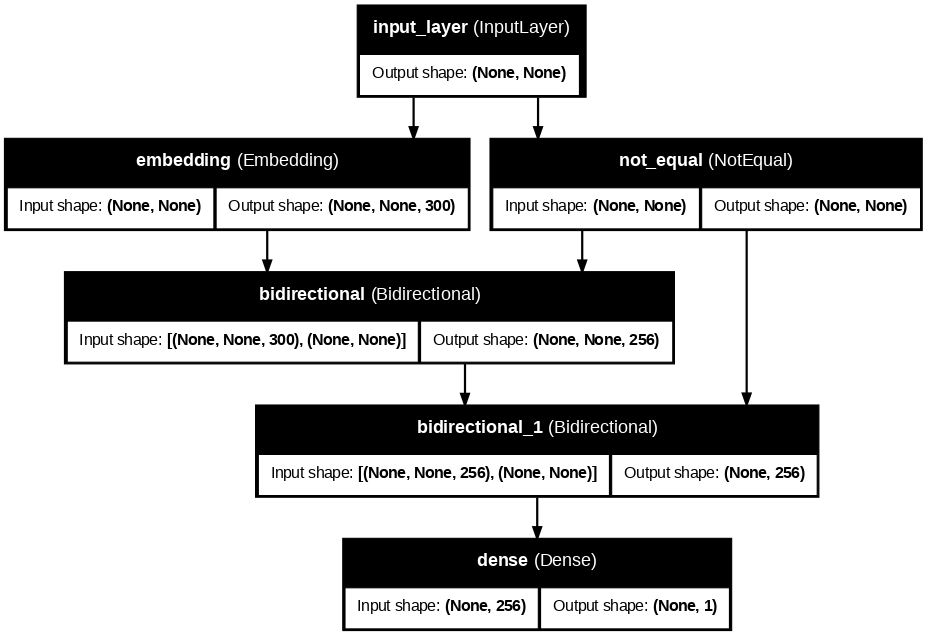

In [ ]:
from keras.utils import plot_model

# Plot the model architecture
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True, dpi=80)

In [ ]:
average_accuracy = np.mean(all_accuracies)
std_accuracy = np.std(all_accuracies)

average_loss = np.mean(all_losses)
std_loss = np.std(all_losses)

print(f"Average Test Accuracy: {average_accuracy:.4f} ± {std_accuracy:.4f}")
print(f"Average Test Loss: {average_loss:.4f} ± {std_loss:.4f}")

Average Test Accuracy: 0.7646 ± 0.0216
Average Test Loss: 0.5548 ± 0.0362


In [ ]:
# Model 1

prediction = models_list[np.argmax(all_accuracies)].predict(X_test, batch_size=64)
prediction = (prediction > 0.5).astype(int)
print(classification_report(y_test, prediction))

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 334ms/step
              precision    recall  f1-score   support

         0.0       0.78      0.85      0.81       160
         1.0       0.79      0.70      0.74       126

    accuracy                           0.78       286
   macro avg       0.78      0.77      0.78       286
weighted avg       0.78      0.78      0.78       286



# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [ ]:
! pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, precision_recall_curve, auc
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
train_df = reading_file('/content/drive/MyDrive/unibo-3/NLP/assign_1/data/training.json')
valid_df = reading_file('/content/drive/MyDrive/unibo-3/NLP/assign_1/data/validation.json')
test_df = reading_file('/content/drive/MyDrive/unibo-3/NLP/assign_1/data/test.json')

In [ ]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)


train_df['preprocessed_text'] = train_df.tweet.apply(preprocess)
valid_df['preprocessed_text'] = valid_df.tweet.apply(preprocess)
test_df['preprocessed_text'] = test_df.tweet.apply(preprocess)

train_label = train_df.hard_label_task1.astype(int).to_list()
valid_label = valid_df.hard_label_task1.astype(int).to_list()
test_label = test_df.hard_label_task1.astype(int).to_list()


task='hate'
MODEL = f"cardiffnlp/twitter-roberta-base-{task}"

tokenizer = AutoTokenizer.from_pretrained(MODEL)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["preprocessed_text"], padding="max_length", truncation=True)

train_dataset = Dataset.from_dict({
    "preprocessed_text": train_df["preprocessed_text"].tolist(),
    "labels": train_label
})
valid_dataset = Dataset.from_dict({
    "preprocessed_text": valid_df["preprocessed_text"].tolist(),
    "labels": valid_label
})
test_dataset = Dataset.from_dict({
    "preprocessed_text": test_df["preprocessed_text"].tolist(),
    "labels": test_label
})

train_dataset = train_dataset.map(tokenize_function, batched=True)
valid_dataset = valid_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset = train_dataset.remove_columns(["preprocessed_text"])
valid_dataset = valid_dataset.remove_columns(["preprocessed_text"])
test_dataset = test_dataset.remove_columns(["preprocessed_text"])

train_dataset.set_format("torch")
valid_dataset.set_format("torch")
test_dataset.set_format("torch")

# Load model
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=2)

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,          # Keep the best epoch
    metric_for_best_model="f1",
    greater_is_better=True,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-9-12fa87b0158d>:31: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.385800,0.291390,0.892405,0.870229,0.904762,0.838235
2,0.197100,0.292993,0.886076,0.863636,0.890625,0.838235
3,0.140500,0.397078,0.879747,0.854962,0.888889,0.823529


TrainOutput(global_step=540, training_loss=0.2645462613414835, metrics={'train_runtime': 216.6497, 'train_samples_per_second': 39.742, 'train_steps_per_second': 2.493, 'total_flos': 357931757490480.0, 'train_loss': 0.2645462613414835, 'epoch': 3.0})

In [ ]:
# Save the trained model
trainer.save_model("./best_model")

# Save the tokenizer as well (optional but recommended)
tokenizer.save_pretrained("./best_model")

('./best_model/tokenizer_config.json',
 './best_model/special_tokens_map.json',
 './best_model/vocab.json',
 './best_model/merges.txt',
 './best_model/added_tokens.json',
 './best_model/tokenizer.json')

#### Evaluation

In [ ]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)
y_test = predictions.label_ids

print(classification_report(y_test, y_pred, target_names=["Not Sexist", "Sexist"]))

              precision    recall  f1-score   support

  Not Sexist       0.89      0.79      0.84       160
      Sexist       0.77      0.87      0.82       126

    accuracy                           0.83       286
   macro avg       0.83      0.83      0.83       286
weighted avg       0.84      0.83      0.83       286



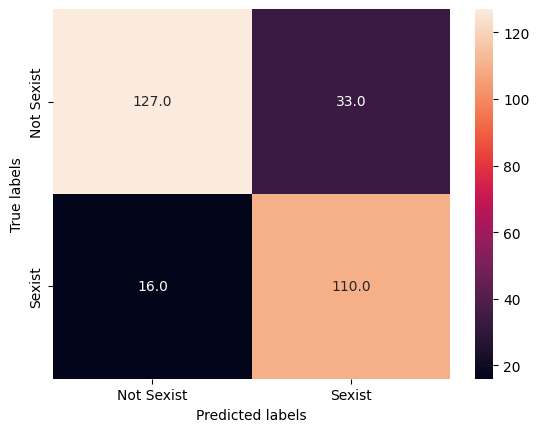

In [ ]:
df_cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
df_cm = pd.DataFrame(df_cm, index=["Not Sexist", "Sexist"], columns=["Not Sexist", "Sexist"])
ax = sn.heatmap(df_cm, annot=True, fmt=".1f")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
plt.show()

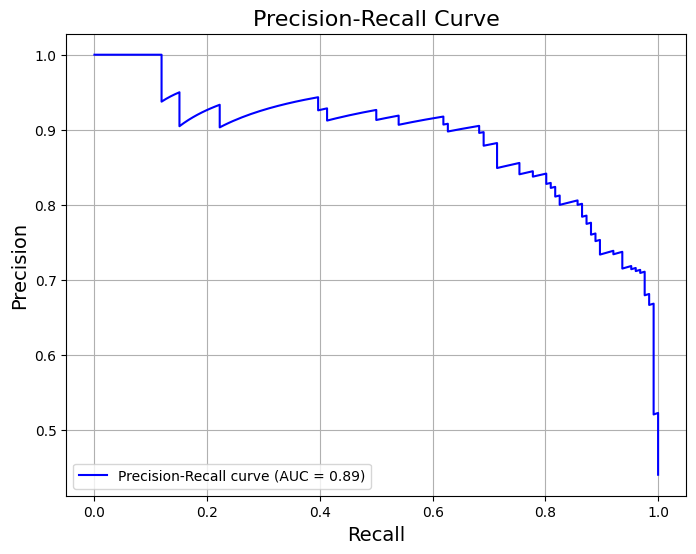

In [ ]:
y_scores = predictions.predictions[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f"Precision-Recall curve (AUC = {pr_auc:.2f})", color="blue")
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall Curve", fontsize=16)
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



In [ ]:
test_df['y_pred'] = y_pred
mismatch_df = test_df[test_df['y_pred'] != test_df['hard_label_task1']][['tweet', 'hard_label_task1']]

The following samples are thoese that model predicit sexist but they are not.



The first things that I noticed is these tweets has **same kind of words** that been used in the sexist's tweets however the **don't specify any gender or women** in it. Although **they are offensive or toxic**, they are **not sexist**. In some cases the tweet is about **specific gender** but it's **not offensive or sexist**.





In [ ]:
mismatch_df[mismatch_df['hard_label_task1'] == 0].tweet.values

array(['“I mean I do, but… wouldn’t it be fun to get gangbanged together~?” https://t.co/lNRZ9z53VL',
       "@LogicalFallac18 @LBC Sex* as in 'gender' harassment is what they are inferring.",
       'Appreciate being included along with @wphillips49 on the Uvalde gunman’s history of cyber gender harassment. Regrettably unshocking. @UVALaw https://t.co/gg1UwHYdIf',
       "@EyemotionFandom How did we reach a point where blonks are having the audacity to talk about yoongis rap do y'all see who you Stan ? Are y'all ok ?? Your girls can't write can't deliver can't come close to bts's lyricism tf are y'all getting brave for ?? Fashion deals ??",
       '@MatrixPirate12 Well let me ask for the guys… do you ever just grab your testicles because you can?',
       '@BoopBepp @Helloth07860784 @Bronwen85 Yup I hate when men rape and kill women. https://t.co/MyfVPu6THd',
       "Ladies,don't let anyone body shame you in any way...you are fat so what..you are beautiful my dear...be confident in yo

The following samples labeled sexist by humans.



*   I think the following tweet is **misclassed by humans**:"According to the Human Rights Commission, 1 in 3 people experience sexual harassment at work. We have created an online course  providing strategies to prevent and respond should incidents occur. Start your course at" because to me it's **NOT SEXIST**.
*   To be honest I even cannot underestand why some of them are sexist.

*   Some of the tweets use possitive language then show their intention by saying something sexist so model became confused.





In [ ]:
mismatch_df[mismatch_df['hard_label_task1'] == 1].tweet.values

array(['@Catoishere @HatClub @RahnniFitteds That gold digger is nice but the picture and set up for them are elite. Pinwork is like the revealing of the Mona Lisa. Always a work of art.',
       "Dear @starwars fans Can we not harass talented actors of color? Stop being racist douche nozzles. This is why we can't have nice things. Moses is a badass inquisitor and y'all can't handle her badassary. https://t.co/bczGdn6evx",
       'stop saying i said this cus she has short hair! some of her gayest looks came from 2017/18 blonde ponytail era!!!!!! know ur herstory https://t.co/YJYVzJVP0L',
       "Calls to clean up Parliament's laddish culture after MP's porn shame https://t.co/3AC2ArWrjF via https://t.co/LiNou8Ixhu",
       '"Dude Looks Like A Lady" 💫🎶Aerosmith🎶🎸⚡️💫https://t.co/41OxpV6YWm',
       'Mansplaining the concept of a pee drawer to my partner (who want me)',
       'wonwoo cross legs &amp; jun manspreading 🦋🦋🦋🦋 @pledis_17 https://t.co/2pFi9Lzeji',
       'Going weak rn... PLAYI

### Error Analysis of LSTM model

In [ ]:
random.sample(oov_words, 20) # OOV sample words

['Flop',
 'nonbinary',
 'Vietnam',
 'Indifference',
 'Portia',
 'debaclearchipiélago',
 'BBB',
 'Funds',
 'masseslet',
 'kehlanis',
 'rekieta',
 'stefMe',
 'mfw',
 'Heroes',
 'rhetorici',
 'Julius',
 'drachen',
 'DeSantis',
 'Envy',
 'Harass']



*   Based on oov words I think it was better if we **decapitalized** words. but because it's not mentioned I **didn't do** it.



In [ ]:
test_df['y_pred'] = prediction
mismatch_df = test_df[test_df['y_pred'] != test_df['hard_label_task1']][['tweet', 'hard_label_task1']]

In [ ]:
mismatch_df[mismatch_df['hard_label_task1'] == 0].tweet.values

array(["@LogicalFallac18 @LBC Sex* as in 'gender' harassment is what they are inferring.",
       'Appreciate being included along with @wphillips49 on the Uvalde gunman’s history of cyber gender harassment. Regrettably unshocking. @UVALaw https://t.co/gg1UwHYdIf',
       'Isa hot girl summer now pop yall shit https://t.co/bU1bzAUuvr',
       '@MatrixPirate12 Well let me ask for the guys… do you ever just grab your testicles because you can?',
       '@OfficialDGISPR u r allowing these terrorists to harass the countrymen https://t.co/8DOaqn4WiT',
       '@BoopBepp @Helloth07860784 @Bronwen85 Yup I hate when men rape and kill women. https://t.co/MyfVPu6THd',
       "Ladies,don't let anyone body shame you in any way...you are fat so what..you are beautiful my dear...be confident in yourself...peace",
       'not all men look good with beard btw, pls stop trying to grow it out\U0001fae3',
       '@SeanMc46114355 @piscesflowers On the audio from when his finger was cut off ! Even the  peop

In [ ]:
mismatch_df[mismatch_df['hard_label_task1'] == 1].tweet.values

array(['@FernsLewds “Mmm, fuck that cunt is hungry for this dick isn’t it~ Such a shame that you can lie all you want about not wanting this but your body never can~”He says in her ear before he starts kissing down her neck. Making sure to leave plenty of love marks on her pale skin.',
       'Suika gets gangbanged to death https://t.co/vna0ZwRtRN',
       '@Fox_x_Gods Maybe something involving her getting gangbanged~?',
       '"The violent antifeminism of a far-right movement that sees ♀️ principally as vessels for breeding a new white generation expresses itself in a fixation on a\xa0return to “traditional” gender roles"Worth every minute to read - take 5 min out of your Sun👇https://t.co/zkdWPpIlzZ',
       '@Catoishere @HatClub @RahnniFitteds That gold digger is nice but the picture and set up for them are elite. Pinwork is like the revealing of the Mona Lisa. Always a work of art.',
       'Aughhh i still got an exam tomorrow. I hate women',
       '@Schneiv @BillKristol They tell

# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End